In [29]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [27,41,-12,2]
mapproj = cartopy.crs.PlateCarree()

datasets = ["cpc", "mswep", "chirps", "tamsat"]

In [16]:
sf = gpd.read_file("sf")

In [66]:
from taylorDiagram import TaylorDiagram, taylor_scores

# HighResMIP

## Spatial pattern (1990-2020 MAM climatology)

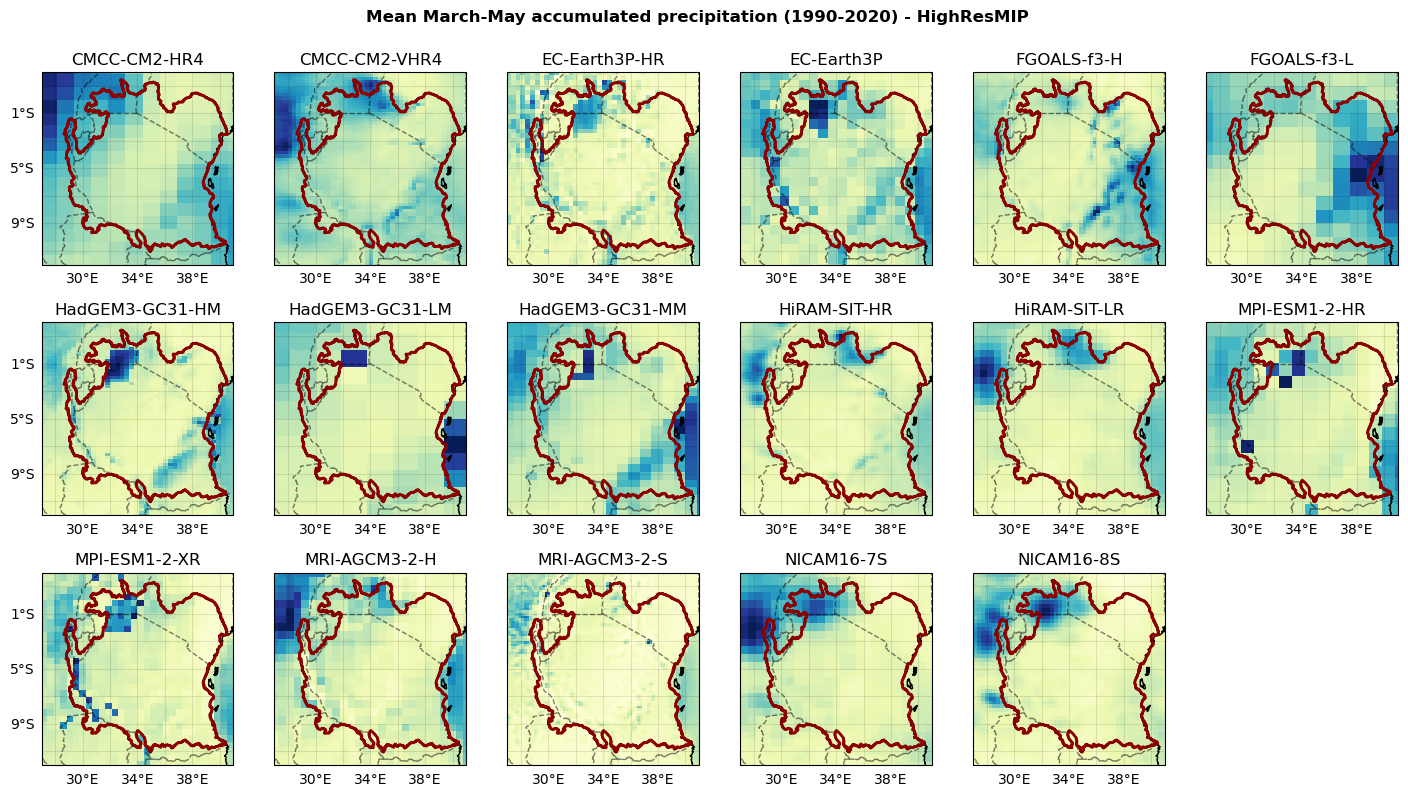

In [61]:
fl = sorted(glob.glob("data/highresMIP/*spatial*"))

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (6*3,3*3), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01, hspace = 0.3)

for i in range(len(fl)):
    fnm = fl[i]
    mdl = fnm.split("_")[2]
    
    da = xr.open_dataset(fnm).pr
    ax = fig.axes[i]
    
    cbar = da.plot(ax = ax, vmin = 0, cmap = "YlGnBu", add_colorbar = False) 
    ax.set_title(mdl)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
        
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()

for ax in axs[:,0]: ax.gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Mean March-May accumulated precipitation (1990-2020) - HighResMIP", fontweight = "bold", y = 0.95)

plt.savefig("fig/model-eval_highresmip_mam-climatology.png")

## Seasonal cycle (1990-2020 MAM climatology)

In [64]:
fl = sorted(glob.glob("data/highresMIP/pr_seasonal*"))

sc_obs = xr.concat([xr.open_dataset("data/daily-ts_org_"+ds+".nc").pr.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean().expand_dims(ds = [ds]) for ds in datasets], "ds").transpose().to_pandas()

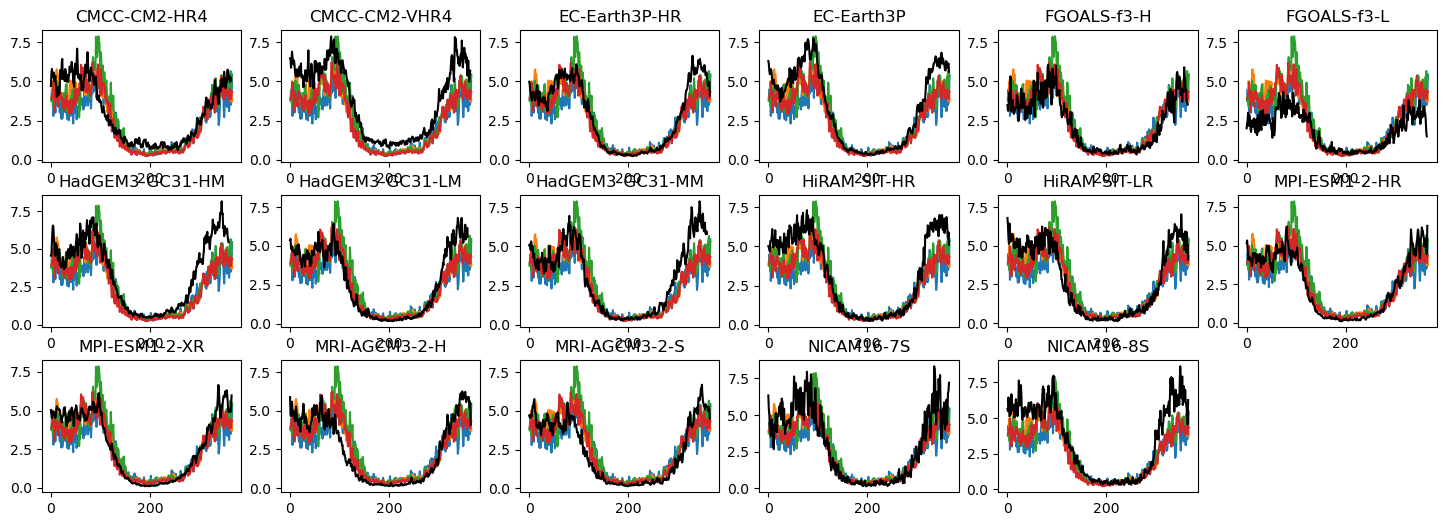

In [65]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (6*3, 3*2), dpi = 100)
plt.subplots_adjust(hspace = 0.25)

for i in range(len(fl)):
    ax = fig.axes[i]
    fnm = fl[i]
    
    mdl = fnm.split("_")[2]
    
    sc_obs.plot(ax = ax, legend = False)
    ax.plot(xr.open_dataset(fnm).pr, color = "k")
    
    ax.set_title(mdl)
    ax.set_xlabel("")
    
if len(fig.axes) > len(fl):
    for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()


### Taylor diagram

In [90]:
sc_obs = xr.concat([xr.open_dataset("data/daily-ts_org_"+ds+".nc").pr.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean().expand_dims(ds = [ds]) for ds in datasets], "ds")
sc_mdl = xr.concat([xr.open_dataset(fnm).pr.expand_dims(mdl = [fnm.split("_")[2]]) for fnm in sorted(glob.glob("data/highresMIP/pr_seasonal*"))], "mdl")

In [91]:
# get correlations & standard deviations
obs_corrs, obs_sds, ref_sd = taylor_scores(sc_obs, sc_obs.sel(ds = "tamsat", drop = True))
corrs, sds, ref_sd = taylor_scores(sc_mdl, sc_obs.sel(ds = "tamsat", drop = True))

max_sd = max(np.ceil(max(sds) / ref_sd), 1.1)
min_corr = min(corrs)

In [150]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : cordex.run.values, "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[:, "eval"] = "bad"
td_df.loc[(td_df.cor >= 0.8) | ((td_df.sd <= 2*ref_sd) & (td_df.sd >= 0.5*ref_sd)), "eval"] = "reasonable"
td_df.loc[(td_df.cor >= 0.8) & (td_df.sd <= 2*ref_sd) & (td_df.sd >= 0.5*ref_sd), "eval"] = "good"

td_df.sort_index().to_csv("res/seasonal-cycle_pr_cordex-"+domain+"_taylor-scores.csv")

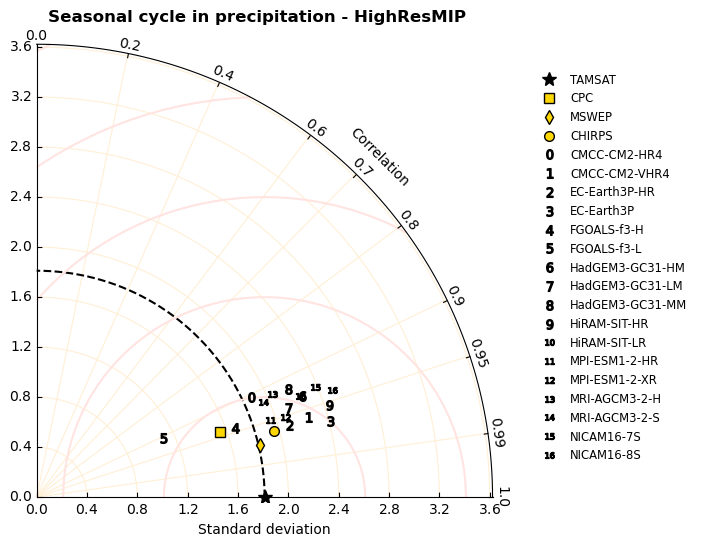

In [115]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "TAMSAT", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(obs_corrs)):
    if sc_obs.ds[i] == "tamsat": continue
    markers = ["s", "d", "o", "*"]
    td.add_sample(obs_sds[i], obs_corrs[i], marker = markers[i], ms = 7, ls = '', mfc = "gold", mec = "k", label = sc_obs.ds.values[i].upper(), zorder = 9)

for i in range(len(corrs)):
    
    mdl = sc_mdl.mdl.values[i]
    gcm_marker = "$"+str(i)+"$"
    rcm_colour = "k"
    
    # change border width depending on model resolution
    mew = 1
    if mdl.split("_")[0][-2:] == "22": mew = 1
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "k", label = mdl, mew = mew, zorder = 9)
    
    # highlight category each falls into
    # bg_col = {"good" : "green", "reasonable" : "orange", "bad" : "red"}[td_df.loc[mdl,"eval"]]
    # td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 11, ls = '', mfc = bg_col, mec = bg_col, label = "_", zorder = 8)

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation - HighResMIP", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/seasonal-cycle_pr-org_highresmip_taylor-diagram.png")